# Melhores e piores meses para vender carros usados no Brasil

A demanda por carros usados no Brasil varia ao longo do ano, influenciada por diversos fatores como sazonalidade, datas comemorativas, condições econômicas e lançamento de novos modelos. Historicamente, os meses que costumam apresentar maior taxa de vendas de carros usados são:

- Agosto, setembro e dezembro: Essas épocas são marcadas por um aumento significativo na procura, impulsionado por fatores como o pagamento do 13º salário, férias e o desejo de renovar a frota antes do final do ano.

Já os meses com menor taxa de vendas, geralmente, são:

- Janeiro, fevereiro e março: Nesses meses, os consumidores costumam estar mais preocupados com dívidas contraídas no final do ano (IPTU, IPVA, material escolar, etc.) e com os gastos relacionados às férias.

É importante ressaltar que essas tendências podem variar de um ano para outro e são influenciadas por diversos fatores. Por que essas variações acontecem?

- Sazonalidade: Férias, feriados prolongados e datas comemorativas como o Natal impulsionam o consumo.

-	Lançamento de novos modelos: O lançamento de novos modelos de carros zero km costuma gerar uma maior procura e, consequentemente, uma maior rotatividade de carros usados.


# Importação das bibliotecas

In [ ]:
import csv
import random
import string
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Criação do Dataset

In [ ]:
# gerar placa aleatória e única
def gerar_placa():
    letras = ''.join(random.choices(string.ascii_uppercase, k=3))
    numeros = ''.join(random.choices(string.digits, k=2))
    numero_meio = random.choice(string.digits)
    letra_meio = random.choice(string.ascii_uppercase)
    return f"{letras}{numero_meio}{letra_meio}{numeros}"

# dicionário: marca, modelo e carroceria
carros = {
    "Chevrolet": [("Onix", "Hatchback"), ("Prisma", "Sedan"), ("Tracker", "SUV")],
    "Volkswagen": [("Gol", "Hatchback"), ("Polo", "Hatchback"), ("T-Cross", "SUV")],
    "Fiat": [("Palio", "Hatchback"), ("Siena", "Sedan"), ("Strada", "Picape")],
    "Toyota": [("Corolla", "Sedan"), ("Yaris", "Hatchback"), ("Hilux", "Picape")],
    "Honda": [("Civic", "Sedan"), ("Fit", "Hatchback"), ("HR-V", "SUV")],
    "Ford": [("Ka", "Hatchback"), ("Ranger", "Picape"), ("EcoSport", "SUV")],
}

# faixa de preço por carroceria
preco_faixas = {
    "Hatchback": (10000, 25000),
    "Sedan": (18000, 50000),
    "SUV": (50000, 100000),
    "Picape": (20000, 40000),
    "Perua": (15000, 30000),
}

# configuração de cada carro
def gerar_configuracao_carro():
    marca = random.choice(list(carros.keys()))
    modelo, carroceria = random.choice(carros[marca])
    placa = gerar_placa()
    ano_modelo = random.randint(2010, 2016)  # ano modelo entre 2010 e 2016

    # ajuste do preço baseado na carroceria e no ano modelo
    faixa_preco = preco_faixas[carroceria]
    preco_venda = round(random.uniform(*faixa_preco) * (1 + 0.05 * (ano_modelo - 2010)), 2)

    return {
        "Placa": placa,
        "Marca": marca,
        "Modelo": modelo,
        "Carroceria": carroceria,
        "AnoModelo": ano_modelo,
        "PreçoVenda": preco_venda,
    }

start_date = datetime(2017, 1, 1)
days = 2556  # 7 anos de dados

# função para gerar o padrão de vendas com sazonalidade mensal
def generate_sales(current_date):
    # definindo um padrão de sazonalidade mensal
    month = current_date.month
    sazonalidade_mensal = [1.0, 0.90, 0.90, 0.90, 0.95, 0.90, 0.95, 1.0, 1.05, 1.1, 1.1, 1.15]

    # calcula as vendas com base na sazonalidade
    sazonalidade = sazonalidade_mensal[month - 1]
    vendas_iniciais = random.randint(1500, 2500)
    quantidade_vendida = int(vendas_iniciais * sazonalidade)

    return quantidade_vendida

# crescimento exponencial
def apply_exponential_growth(vendas, current_date):
    if current_date.year >= 2018:
        # Fator de crescimento exponencial
        years_since_2018 = current_date.year - 2018
        growth_factor = math.exp(0.1 * years_since_2018)
        vendas = int(vendas * growth_factor)
    return vendas

# gerar dataset
data = []
for day_offset in range(days):
    current_date = start_date + timedelta(days=day_offset)
    carro = gerar_configuracao_carro()  # Gera uma nova configuração de carro a cada dia
    quantidade_vendida = generate_sales(current_date)
    quantidade_vendida = apply_exponential_growth(quantidade_vendida, current_date)

    venda = {
        "Placa": carro["Placa"],
        "Marca": carro["Marca"],
        "Modelo": carro["Modelo"],
        "Carroceria": carro["Carroceria"],
        "AnoModelo": carro["AnoModelo"],
        "QuantidadeVendida": quantidade_vendida,
        "AnoMes": current_date.strftime('%Y-%m-%d'),
        "PreçoVenda": carro["PreçoVenda"],
    }

    data.append(venda)

# escrita em CSV
csv_file = 'dados_venda_carros.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=data[0].keys())
    writer.writeheader()
    writer.writerows(data)

df = pd.read_csv('dados_venda_carros.csv')

# converter a coluna AnoMes para datetime
df['AnoMes'] = pd.to_datetime(df['AnoMes'])

# agrupar os dados por mês
df['AnoMes'] = df['AnoMes'].dt.to_period('M')

print(f"Arquivo CSV '{csv_file}' gerado com sucesso.")

Arquivo CSV 'dados_venda_carros.csv' gerado com sucesso.


In [ ]:
# verificando se há placas duplicadas:

print(df['Placa'].duplicated().any())

False


# Visualização da série

In [ ]:
df

,Placa,Marca,Modelo,Carroceria,AnoModelo,QuantidadeVendida,AnoMes,PreçoVenda
0,NTS1E95,Honda,Civic,Sedan,2015,2194,2017-01,38387.45
1,ZDL6Q62,Fiat,Siena,Sedan,2012,2142,2017-01,29618.80
2,USI2I24,Ford,Ranger,Picape,2015,1994,2017-01,38593.55
3,DJX6S43,Toyota,Yaris,Hatchback,2011,2113,2017-01,21633.22
4,YBS7U78,Fiat,Siena,Sedan,2010,1704,2017-01,44004.17
...,...,...,...,...,...,...,...,...
2551,IQZ3Q48,Honda,Fit,Hatchback,2013,3144,2023-12,22044.63
2552,TEJ5L58,Honda,Civic,Sedan,2012,4540,2023-12,31133.34
2553,WZT4P46,Volkswagen,T-Cross,SUV,2016,4723,2023-12,124717.37
2554,MOU1R43,Chevrolet,Prisma,Sedan,2012,4344,2023-12,39532.21


In [ ]:
df.describe()

,AnoModelo,QuantidadeVendida,PreçoVenda
count,2556.000000,2556.000000,2556.000000
mean,2013.035211,2501.215180,41564.449460
std,2.003014,613.309149,27848.965213
min,2010.000000,1350.000000,10019.080000
25%,2011.000000,2045.000000,21652.017500
50%,2013.000000,2417.000000,30301.115000
75%,2015.000000,2877.250000,52898.960000
max,2016.000000,4723.000000,129918.670000


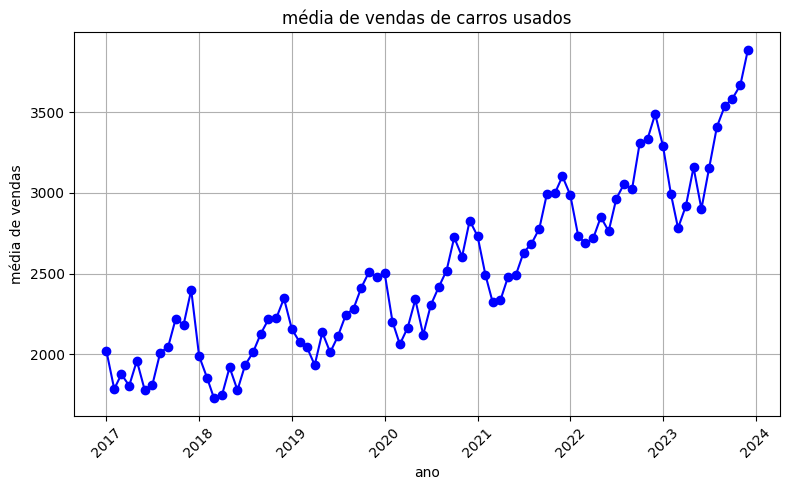

In [ ]:
venda_mensal = df.groupby('AnoMes')['QuantidadeVendida'].mean().reset_index()

# datetime: facilitar a plotagem
venda_mensal['AnoMes'] = venda_mensal['AnoMes'].dt.to_timestamp()

# Plotar os dados mensais
plt.figure(figsize=(8, 5))
plt.plot(venda_mensal['AnoMes'], venda_mensal['QuantidadeVendida'], marker='o', color='blue')
plt.title('média de vendas de carros usados')
plt.xlabel('ano')
plt.ylabel('média de vendas')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

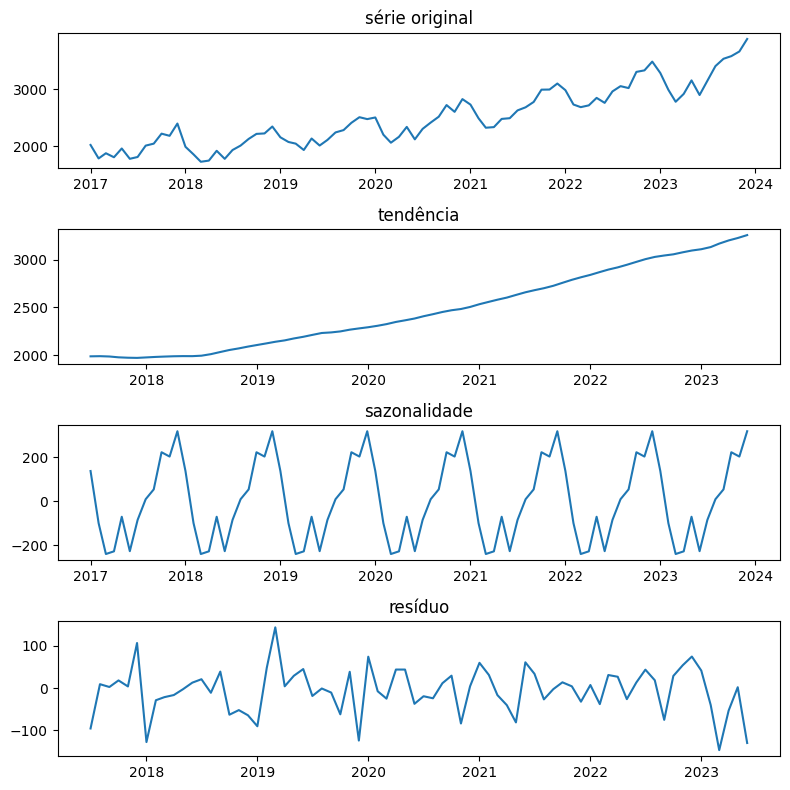

In [ ]:
# decomposição da série temporal
venda_mensal.set_index('AnoMes', inplace=True)
result = seasonal_decompose(venda_mensal['QuantidadeVendida'], model='additive', period=12)

plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(venda_mensal.index, venda_mensal['QuantidadeVendida'], label='Original')
plt.title('série original')
plt.subplot(412)
plt.plot(result.trend.index, result.trend, label='Trend')
plt.title('tendência')
plt.subplot(413)
plt.plot(result.seasonal.index, result.seasonal, label='Seasonal')
plt.title('sazonalidade')
plt.subplot(414)
plt.plot(result.resid.index, result.resid, label='Residual')
plt.title('resíduo')
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

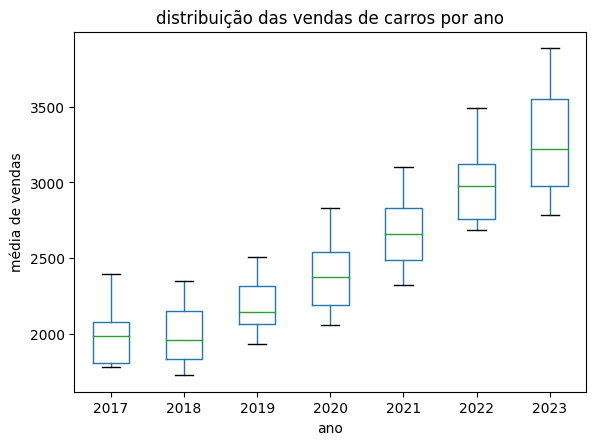

In [ ]:
# distribuição das vendas de carros por ano

# somar as vendas por mês
vendas_anuais = df.groupby('AnoMes')['QuantidadeVendida'].mean().reset_index()

# extrair ano
vendas_anuais['Ano'] = vendas_anuais['AnoMes'].dt.year

# boxplot por ano
plt.figure(figsize=(8, 8))
vendas_anuais.boxplot(column='QuantidadeVendida', by='Ano', grid=False)
plt.title('distribuição das vendas de carros por ano')
plt.suptitle('')
plt.xlabel('ano')
plt.ylabel('média de vendas')
plt.show()

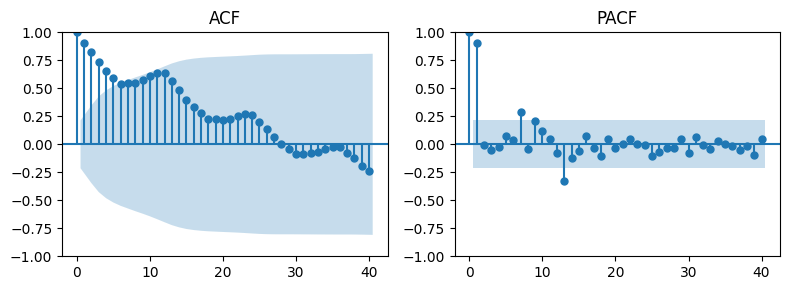

In [ ]:
# ACF e PACF
plt.figure(figsize=(8, 3))

plt.subplot(121)
plot_acf(venda_mensal['QuantidadeVendida'].dropna(), lags=40, ax=plt.gca())
plt.title("ACF")

plt.subplot(122)
plot_pacf(venda_mensal['QuantidadeVendida'].dropna(), lags=40, ax=plt.gca())
plt.title("PACF")

plt.tight_layout()
plt.show()

- se as autocorrelações do ACF decaem lentamente com o aumento dos lags, isso pode indicar que a série temporal possui uma tendência.

- um padrão de oscilações no ACF pode sugerir que a série é sazonal.

- se os valores de ACF ou PACF caem dentro do intervalo de confiança, a correlação observada pode ser atribuída ao acaso, e esses lags não têm um impacto significativo sobre os valores futuros da série.

In [ ]:
# verificar estacionaridade: Dickey-Fuller Aumentado (ADF)

venda_mensal['Log_QuantidadeVendida'] = np.log(venda_mensal['QuantidadeVendida'].replace(0, np.nan)).dropna()
adf_result = adfuller(venda_mensal['Log_QuantidadeVendida'].dropna())

print("teste Dickey-Fuller Aumentado para verificar estacionariedade da série:")
print(f"estatística ADF: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("a série é estacionária.")
else:
    print("a série não é estacionária.")

teste Dickey-Fuller Aumentado para verificar estacionariedade da série:
estatística ADF: 1.82951062709043
p-value: 0.998405785368418
a série não é estacionária.


- estatística ADF: um valor positivo da estatística ADF é incomum para séries estacionárias. valores negativos são mais esperados para séries estacionárias.

- p-value: um p-value próximo de 1 indica que não há evidências para rejeitar a hipótese nula, o que sugere fortemente que a série não é estacionária.

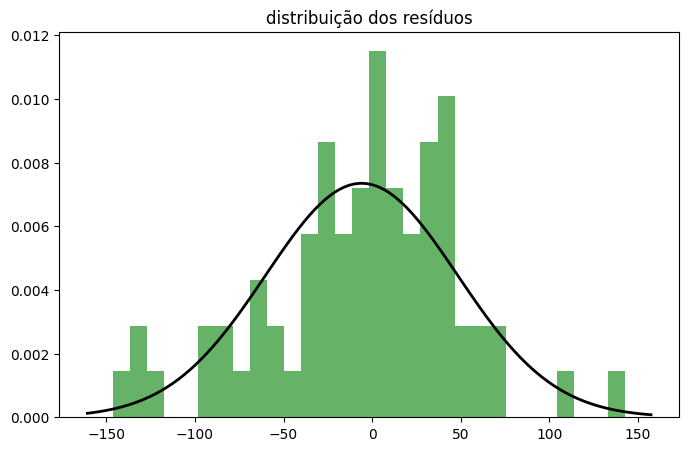


teste Shapiro-Wilk para resíduos:
estatística W: 0.976537340727969
p-value: 0.19755101111429318


In [ ]:
# análise da distribuição normal dos resíduos
residuals = result.resid.dropna()
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title("distribuição dos resíduos")
plt.show()

# teste de normalidade Shapiro-Wilk
shapiro_test = shapiro(residuals)
print(f"\nteste Shapiro-Wilk para resíduos:")
print(f"estatística W: {shapiro_test[0]}")
print(f"p-value: {shapiro_test[1]}")

- estatística W: se este valor está próximo de 1, sugere que os resíduos se ajustam razoavelmente bem a uma distribuição normal

- p-value: se o p-value é maior que 0,05 não há evidências suficientes para rejeitar a hipótese nula, significando que os resíduos do modelo seguem uma distribuição normal.

# Treino e Teste

- no modelo SARIMA, parâmetro "order=(p,d,q)" com valor d=1 indica que uma diferenciação (diferença) de ordem 1 foi aplicada à série original para torná-la estacionária. isso significa que o modelo subtrai cada valor da série pelo valor anterior, removendo tendências lineares e ajudando a estabilizar a média da série ao longo do tempo.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


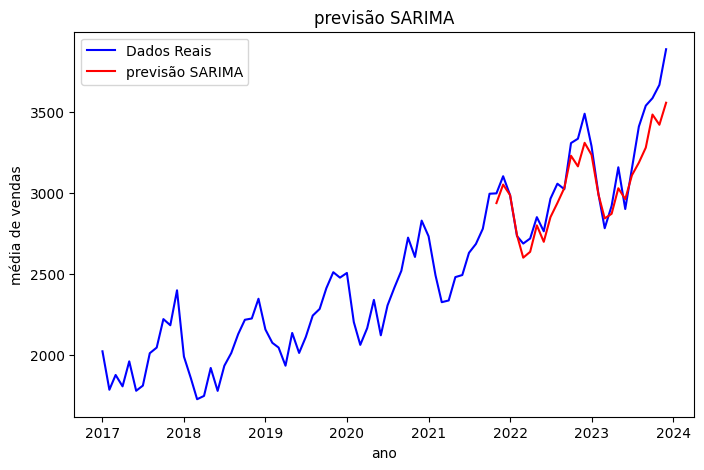


ME: 90.87
MAE: 101.24
RMSE: 131.71
MPE: 2.71%
MAPE: 3.08%

acurácia do modelo SARIMA: 96.76%


In [ ]:
venda_mensal = df.groupby('AnoMes')['QuantidadeVendida'].mean().reset_index()
venda_mensal['AnoMes'] = venda_mensal['AnoMes'].dt.to_timestamp()

# treino e teste
train_size = int(len(venda_mensal) * 0.7)
train, test = venda_mensal[:train_size], venda_mensal[train_size:]

# modelagem com SARIMA
sarima_model = SARIMAX(train['QuantidadeVendida'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12)).fit(disp=False)

pred_sarima = sarima_model.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(8, 5))
plt.plot(venda_mensal['AnoMes'], venda_mensal['QuantidadeVendida'], label='Dados Reais', color='blue')
plt.plot(test['AnoMes'], pred_sarima, label='previsão SARIMA', color='red')
plt.legend()
plt.xlabel('ano')
plt.ylabel('média de vendas')
plt.title('previsão SARIMA')
plt.show()

# métricas de erro
# erro médio (ME)
me = np.mean(test['QuantidadeVendida'] - pred_sarima)

# erro médio absoluto (MAE)
mae = mean_absolute_error(test['QuantidadeVendida'], pred_sarima)

# erro quadrático médio (RMSE)
rmse = np.sqrt(np.mean((test['QuantidadeVendida'] - pred_sarima) ** 2))

# erro percentual médio (MPE)
mpe = np.mean((test['QuantidadeVendida'] - pred_sarima) / test['QuantidadeVendida']) * 100

# erro percentual médio absoluto (MAPE)
mape = np.mean(np.abs((test['QuantidadeVendida'] - pred_sarima) / test['QuantidadeVendida'])) * 100

# Printar as métricas
print(f"\nME: {me:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"MAPE: {mape:.2f}%")

# cálculo da acurácia do modelo SARIMA
mean_actual = np.mean(test['QuantidadeVendida'])
accuracy_percentage = 100 * (1 - (mae / mean_actual))
print(f"\nacurácia do modelo SARIMA: {accuracy_percentage:.2f}%")

# Previsão para 2024

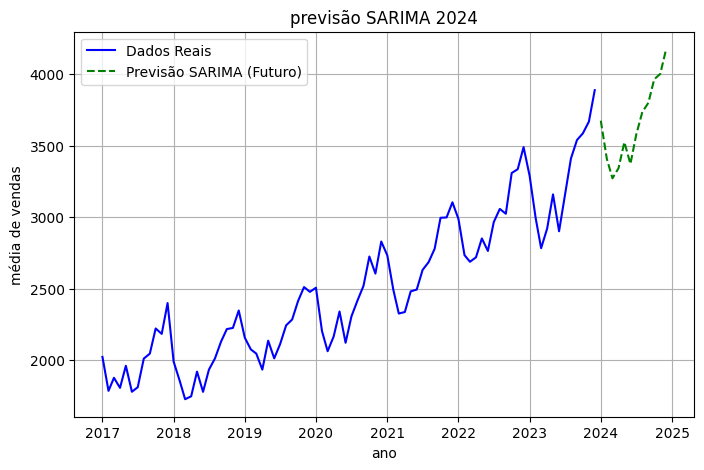

In [ ]:
# modelagem com SARIMA
sarima_model = SARIMAX(venda_mensal['QuantidadeVendida'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12)).fit(disp=False)

# previsão para 2024
future_dates = pd.date_range(start='2024-01', end='2024-12', freq='MS')
future_preds = sarima_model.get_forecast(steps=len(future_dates)).predicted_mean

# dataframe para previsões futuras
future_df = pd.DataFrame({
    'AnoMes': future_dates,
    'QuantidadeVendida': future_preds
})

plt.figure(figsize=(8, 5))
plt.plot(venda_mensal['AnoMes'], venda_mensal['QuantidadeVendida'], label='Dados Reais', color='blue')
plt.plot(future_df['AnoMes'], future_df['QuantidadeVendida'], label='Previsão SARIMA (Futuro)', color='green', linestyle='--')
plt.legend()
plt.xlabel('ano')
plt.ylabel('média de vendas')
plt.title('previsão SARIMA 2024')
plt.grid(True)
plt.show()

<Figure size 800x800 with 0 Axes>

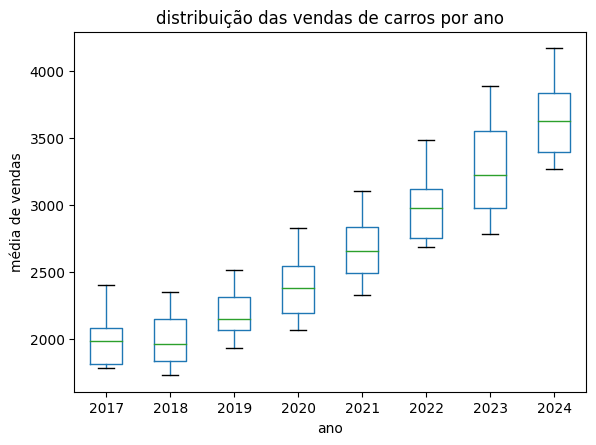

In [ ]:
# distribuição das vendas de carros por ano com 2024
future_df['Ano'] = future_df['AnoMes'].dt.year

venda_mensal['Ano'] = venda_mensal['AnoMes'].dt.year
venda_mensal = pd.concat([venda_mensal, future_df], ignore_index=True)

plt.figure(figsize=(8, 8))
boxplot = venda_mensal.boxplot(column='QuantidadeVendida', by='Ano', grid=False)
plt.title('distribuição das vendas de carros por ano')
plt.suptitle('')
plt.xlabel('ano')
plt.ylabel('média de vendas')
plt.show()

In [ ]:
# Calcular as vendas totais para cada ano
vendas_totais = {}
for ano in range(2017, 2025):
    if ano == 2024:
        vendas_totais[ano] = future_df[future_df['AnoMes'].dt.year == ano]['QuantidadeVendida'].sum()
    else:
        vendas_totais[ano] = venda_mensal[venda_mensal['AnoMes'].dt.year == ano]['QuantidadeVendida'].sum()

# Calcular o crescimento percentual ano a ano
crescimento_percentual = {}
for ano in range(2018, 2025):
    ano_anterior = ano - 1
    if vendas_totais[ano_anterior] != 0:  # Evitar divisão por zero
        crescimento = ((vendas_totais[ano] - vendas_totais[ano_anterior]) / vendas_totais[ano_anterior]) * 100
        crescimento_percentual[f'{ano} em relação a {ano_anterior}'] = crescimento

# Exibir os resultados
for periodo, crescimento in crescimento_percentual.items():
    print(f"crescimento percentual de {periodo}: {crescimento:.2f}%")

crescimento percentual de 2018 em relação a 2017: -0.08%
crescimento percentual de 2019 em relação a 2018: 10.56%
crescimento percentual de 2020 em relação a 2019: 9.11%
crescimento percentual de 2021 em relação a 2020: 11.31%
crescimento percentual de 2022 em relação a 2021: 12.08%
crescimento percentual de 2023 em relação a 2022: 9.38%
crescimento percentual de 2024 em relação a 2023: 11.60%
